## Random Forests Interpretation

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [2]:
import matplotlib.pyplot as plt

from ai import *
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (20, 7)

PATH = "../resources"

In [3]:
def RMSE(predicted, actual): 
    return np.sqrt(np.square(predicted - actual).mean())

def split_to_training_and_validation(dataframe,sample_size): 
    return dataframe[:sample_size].copy(), dataframe[sample_size:].copy()
 
def print_score(model):
    results = [RMSE(model.predict(features_training_set), target_training_set), RMSE(model.predict(features_validation_set), target_validation_set), model.score(features_training_set, target_training_set), model.score(features_validation_set, target_validation_set)]
    
    if hasattr(model, 'oob_score_'): 
        results.append(model.oob_score_)

    print(results)

In [4]:
data_raw = pd.read_csv(f'{PATH}/bulldozers_temp.csv', low_memory=True)
raw = data_raw.copy()

data, target, changes = preprocess_dataframe(data_raw, 'SalePrice') 

In [5]:
# calculate the sizes of the training and validation set
validation_set_size = 12000 
training_set_size = len(data) - validation_set_size

# raw trining and validation set
raw_training_set, raw_validation_set = split_to_training_and_validation(data_raw, training_set_size)

# data ~ data set without traget variable
# target ~ traget variable column
# create separate pairs (features_training_set, target_training_set), (features_validation_set, target_validation_set)
features_training_set, features_validation_set = split_to_training_and_validation(data, training_set_size)
target_training_set, target_validation_set = split_to_training_and_validation(target, training_set_size)

### 1. Confidence Based on Tree Variance

We already saw that model averages prediction across the trees in order to get an estimate. However, we would like to know the confidence interval of the estimate. One simple way is to use the standard deviation of predictions for all trees in the model. This tells us the relative confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of 
using those results, compared to cases where they are more consistent.

In [6]:
model = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=3, max_features=0.5, oob_score=True)
%time model.fit(features_training_set, target_training_set)
print_score(model)

CPU times: user 3min 9s, sys: 3.36 s, total: 3min 13s
Wall time: 35.5 s
[0.12207651019935521, 0.2319803809894059, 0.9688542324996355, 0.9038940029398461, 0.9093043490535504]


In [7]:
%time predictions = np.stack([estimator.predict(features_validation_set) for estimator in model.estimators_])
np.mean(predictions[:,0]), np.std(predictions[:, 0])

CPU times: user 1.45 s, sys: 78.1 ms, total: 1.53 s
Wall time: 1.54 s


(9.145806740542039, 0.13686638389698452)

Let's investigate confidence intervals for the `Enclosure` feature. We grouped values by `Enclosure` type and calculated their mean price, mean value of prediction, and mean value of standard deviation. This way we can show our confidence of predicting the right price per Enclosure type.

<AxesSubplot:>

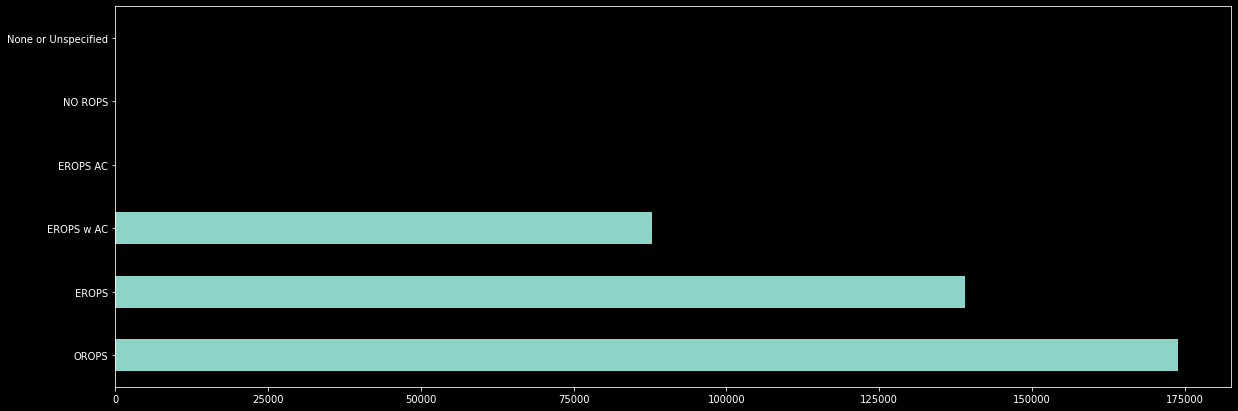

In [16]:
enclosure_summary = features_validation_set.copy()
enclosure_summary['std_of_predictions'] = np.std(predictions, axis=0)
enclosure_summary['prediction'] = np.mean(predictions, axis=0)
enclosure_summary['SalePrice'] = target_validation_set.copy()
raw.Enclosure.value_counts().plot.barh()

<AxesSubplot:ylabel='Enclosure'>

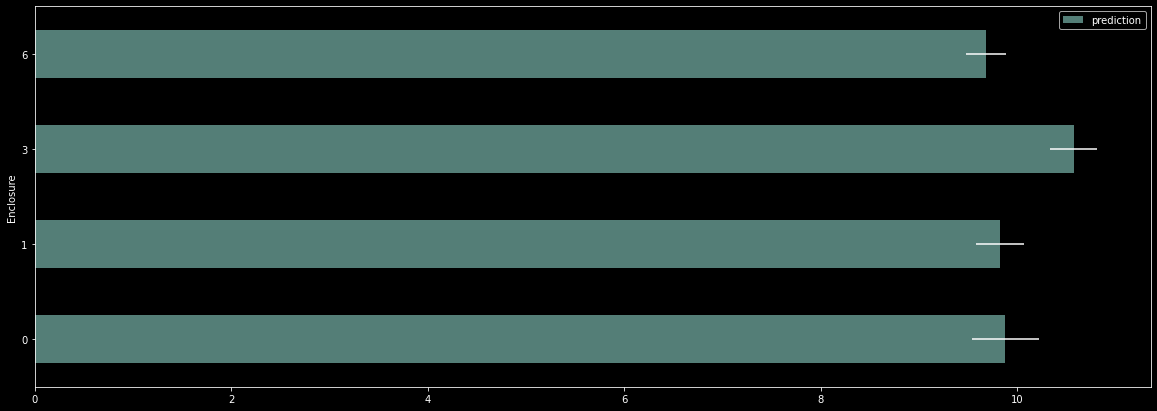

In [39]:
fields = ['Enclosure', 'SalePrice', 'std_of_predictions', 'prediction']
enclosure_summary = enclosure_summary[fields].groupby('Enclosure', as_index=False).mean()
enclosure_summary.plot('Enclosure', 'prediction', 'barh', xerr='std_of_predictions', alpha=0.6)

<AxesSubplot:>

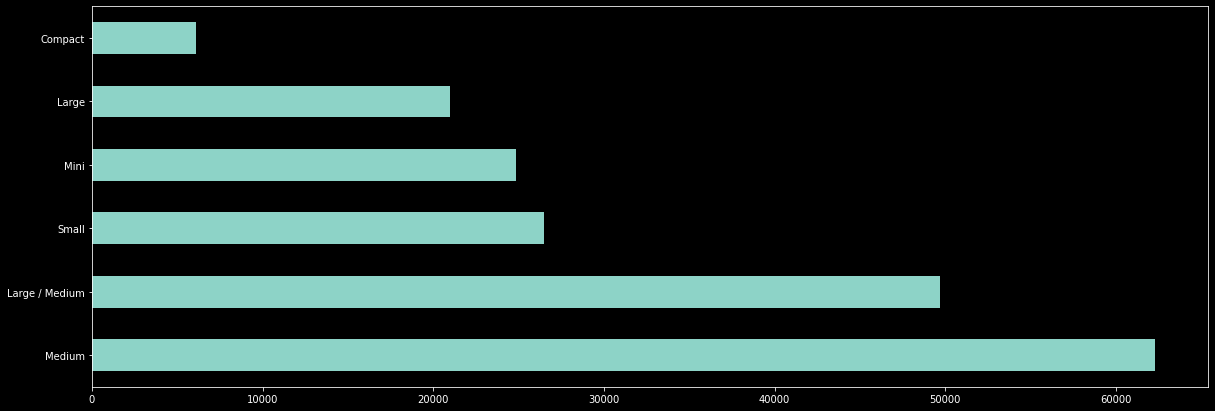

In [40]:
raw.ProductSize.value_counts().plot.barh()

In [43]:
fields = ['ProductSize', 'SalePrice', 'std_of_predictions', 'prediction']
product_size = features_validation_set.copy()
# enclosure_summary = enclosure_summary[fields].groupby('ProductSize', as_index=False).mean()
# enclosure_summary.plot('Enclosure', 'prediction', 'barh', xerr='std_of_predictions', alpha=0.6)

,Enclosure,SalePrice,std_of_predictions,prediction
0,0,9.850807,0.342029,9.878750
1,1,9.849178,0.243306,9.827453
2,3,10.623971,0.241400,10.574931
3,6,9.682064,0.202700,9.680204
